# Precipitation with Elastic Energy

This example will cover adding a strain energy term to the KWN model. This strain energy term will also be used to calculate the aspect ratio as a function of precipitate radius.

## Example - The Cu-Ti system

In copper alloys with dilute amounts of titanium, formation of $\beta$-$Cu_4Ti$, a needle-like precipitate, can occur. Due to volume differences between the precipitate and the parent phase, the parent phase is put under strain. This strain comes with an elastic energy that serves to reduce the driving force for nucleation. In addition, the aspect ratio of the $\beta$ precipitates depends on the size of the precipitate to minimize the elastic and interfacial energy contributions.

To setup the KWN, the PrecipitateModel and BinaryThermodynamics will need to be defined. For BinaryThermodynamics, a mobility correction factor of 100 will be applied. This is to represent the presence of excess quench-in vacancies, which will speed up diffusion.

In [1]:
from kawin.Thermodynamics import BinaryThermodynamics
from kawin.KWNEuler import PrecipitateModel

model = PrecipitateModel(1e-3, 1e5, 5000, phases=['CU4TI'], linearTimeSpacing=False, elements=['TI'])

therm = BinaryThermodynamics('CuTi.tdb', ['CU', 'TI'], ['FCC_A1', 'CU4TI'], interfacialCompMethod='equilibrium')
therm.setMobilityCorrection('all', 100)
therm.setGuessComposition(0.15)

## Model Inputs

For model inputs, the composition will be Cu-1.9Ti (at.%) and the temperature will be $350\text{ }^oC$. The molar volume of the matrix phase will be that of FCC copper with 2 atoms per unit cell. For the $\beta$-$Cu_4Ti$ precipitates, the atomic volume and atoms per unit cell are taken from Ref. 5 from the SpringerMaterials database. Bulk nucleation will be assumed with $1e30\text{ }sites/m^3$.

In [2]:
model.setInitialComposition(0.019)
model.setTemperature(350 + 273.15)
model.setInterfacialEnergy(0.035)
model.setThermodynamics(therm)

VmAlpha = 7.11e-6
model.setVmAlpha(VmAlpha, 4)

VaBeta = 0.25334e-27
model.setVaBeta(VaBeta, 20)

model.setNucleationSite('bulk')
model.setNucleationDensity(bulkN0=1e30)

## Elastic Energy

Elastic energy has to be defined by a separate object, StrainEnergy. Here, the elastic constants and eigenstrains can be defined. It is important to check the order of the axes in the eigenstrains. For needle-like precipitates, the axes are (short axis, short axis, long axis). For plate-like precipitates, the axes are (long axis, long axis, short axis).

When inputting the StrainEnergy object into the KWN model, setting "calculateAspectRatio" to True will allow for the aspect ratio to be calculated from the elastic energy. Otherwise, the aspect ratio will be taken from what was defined when defining the precipitate shape.

In [3]:
from kawin.ElasticFactors import StrainEnergy

se = StrainEnergy()
se.setElasticConstants(168.4e9, 121.4e9, 75.4e9)
se.setEigenstrain([0.022, 0.022, 0.003])

model.setStrainEnergy(se, calculateAspectRatio=True)

#Set precipitate shape
#Since we're calculating the aspect ratio, it does not have to be defined
#Otherwise, a constant value or function can be inputted
model.setAspectRatioNeedle()

## Solving the model

In [4]:
model.solve(verbose=True, vIt=2000)

c:\Users\nury\Anaconda3\lib\site-packages\pycalphad\core\utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


N	Time (s)	Temperature (K)	Matrix Comp
2000	1.6e+00		623		1.9000

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	CU4TI	0.000e+00		0.0000		0.0000e+00	1.9730e+03

N	Time (s)	Temperature (K)	Matrix Comp
4000	2.3e+02		623		0.3379

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	CU4TI	2.506e+25		8.3499		8.6947e-10	6.3285e+02

Finished in 44.440 seconds.


## Plotting

As with the other examples, plotting is the same. Some additional things:
1. The variable 'timeUnits' is set to 'min' to plot in minutes rather than seconds
2. The equilibrium matrix composition is plotted to compare with the actual composition.
3. The mean aspect ratio and aspect ratio as a function of radius is plotted

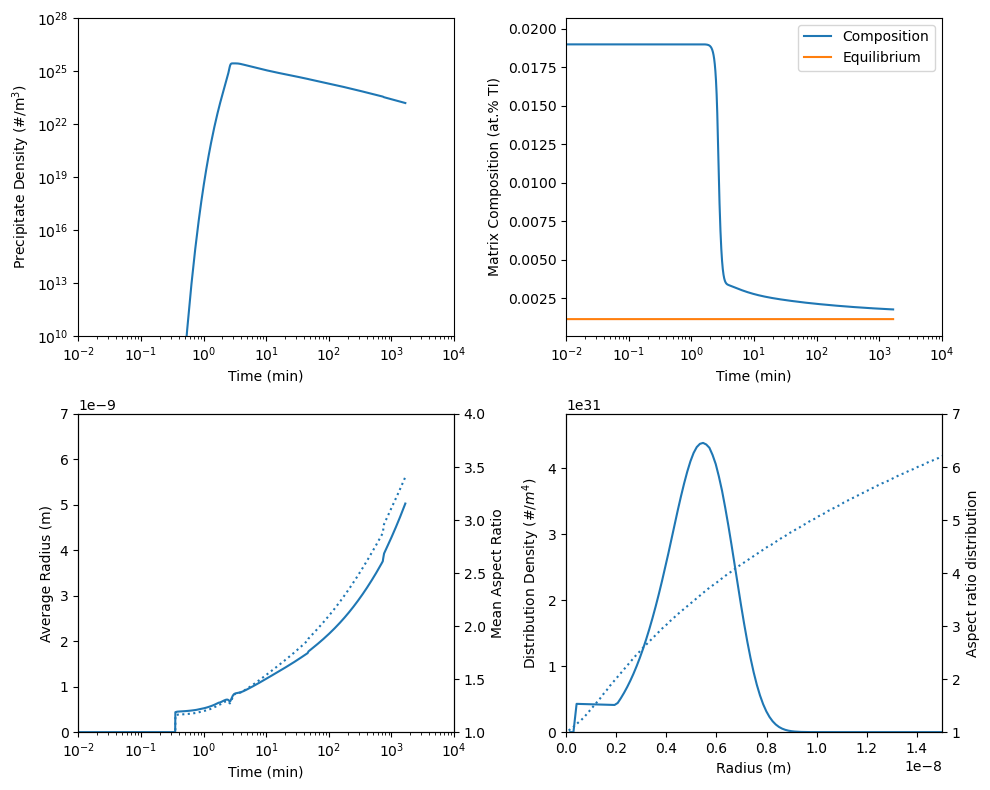

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

model.plot(axes[0,0], 'Precipitate Density', bounds=[1e-2, 1e4], timeUnits='min')
axes[0,0].set_ylim([1e10, 1e28])
axes[0,0].set_yscale('log')

model.plot(axes[0,1], 'Composition', bounds=[1e-2, 1e4], timeUnits='min', label='Composition')
model.plot(axes[0,1], 'Eq Composition Alpha', bounds=[1e-2, 1e4], timeUnits='min', label='Equilibrium')
axes[0,1].legend()

model.plot(axes[1,0], 'Average Radius', bounds=[1e-2, 1e4], timeUnits='min', label='Radius')
axes[1,0].set_ylim([0, 7e-9])

ax1 = axes[1,0].twinx()
model.plot(ax1, 'Aspect Ratio', bounds=[1e-2, 1e4], timeUnits='min', label='Aspect Ratio', linestyle=':')
ax1.set_ylim([1,4])

model.plot(axes[1,1], 'Size Distribution Density', label='PSD')

ax2 = axes[1,1].twinx()
model.plot(ax2, 'Aspect Ratio Distribution', label='Aspect Ratio', linestyle=':')
axes[1,1].set_xlim([0, 1.5e-8])
ax2.set_ylim([1,7])

fig.tight_layout()

## References

1. A. T. Dinsdale, "SGTE Data for Pure Elements" *Calphad* 15 (1991) p. 317
2. J. Wang et al, "Experimental Investigation and Thermodynamic Assessment of the Cu-Sn-Ti Ternary System" *Calphad* 35 (2011) p. 82
3. J. Wang et al, "Assessment of Atomic Mobilities in FCC Cu-Fe and CuTi Alloys" *Journal of Phase Equilibria and Diffusion* 32 (2011) p. 30
4. K. Wu, Q. Chen and P. Mason, "Simulation of Precipitate Kinetics with Non-Spherical Particles" *Journal of Phase Equilibria and Diffusion* 39 (2018) p. 571
5. Eremenko V.N., Buyanov Y.I., Prima S.B., "Phase diagram of the system titanium-copper" *Soviet Powder Metallurgy and Metal Ceramics* 5 (1966) p. 494